In [1]:
import math
import json
import os
import pandas as pd
import numpy as np
from datetime import datetime, timezone, timedelta, time
from research.utils.data_access_utils import RDSAccessUtils
from research.weight_estimation.keypoint_utils.optics import euclidean_distance, pixel2world, depth_from_disp, convert_to_world_point
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateFormatter, AutoDateLocator

rds_access_utils = RDSAccessUtils(json.load(open(os.environ['DATA_WAREHOUSE_SQL_CREDENTIALS'])))

In [2]:
queryCache = {}

In [3]:
pen5 = pd.read_csv('/root/data/bryton/blom_vikane_singleweights.csv')

In [4]:
def getPenDF(pen):
    query = """
       SELECT * FROM prod.biomass_computations
        WHERE prod.biomass_computations.captured_at >= '%s'
        AND prod.biomass_computations.captured_at <= '%s'
        AND prod.biomass_computations.pen_id = '%s';
    """ % (pen['start_date'], pen['end_date'], pen['pen_id'])
    
    if query in queryCache:
        df = queryCache[query].copy()
    else:
        df = rds_access_utils.extract_from_database(query)
        queryCache[query] = df.copy()

    df = df.sort_values('captured_at').copy(deep=True)
    df.index = pd.to_datetime(df.captured_at)
    dates = df.index.date.astype(str)
    df['date'] = dates
    df['hour'] = df.index.hour
    
    depths = []
    for idx, row in df.iterrows():
        ann, cm = row.annotation, row.camera_metadata
        wkps = pixel2world(ann['leftCrop'], ann['rightCrop'], cm)
        depth = np.median([wkp[1] for wkp in wkps.values()])
        depths.append(depth)
    df['depth'] = depths
    
    return df
    
pen1 = {
    'pen_id': 60,
    'start_date': '2020-08-24',
    'end_date': '2020-08-26'
}

df1 = getPenDF(pen1)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/research/weight_estimation/keypoint_utils/optics.py:37: RuntimeWarning: divide by zero encountered in true_divide
  depth = focal_length_pixel * baseline / np.array(disp)


(array([ 454.,   77.,  513., 1183.,  619.,  650.,  850.,  226.,   76.,
         318.]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <a list of 10 Patch objects>)

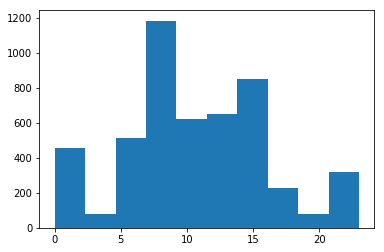

In [18]:
plt.hist(df1.hour)

(array([2.99735481e-06, 1.53198135e-05, 2.80863247e-05, 2.87524036e-05,
        3.17497584e-05, 3.99647309e-05, 5.07330056e-05, 7.28246207e-05,
        1.08792878e-04, 1.56084477e-04, 2.30019229e-04, 3.46361001e-04,
        4.48826130e-04, 4.93120373e-04, 5.65500942e-04, 5.22205817e-04,
        4.80242849e-04, 4.18741569e-04, 3.18718729e-04, 2.51000712e-04,
        1.92052734e-04, 1.31772599e-04, 8.69232896e-05, 5.81708860e-05,
        3.03065876e-05, 1.64299449e-05, 8.43699874e-06, 4.66255193e-06,
        2.88634167e-06, 1.22114455e-06]),
 array([1286.18076444, 1480.62336942, 1675.06597439, 1869.50857937,
        2063.95118435, 2258.39378933, 2452.83639431, 2647.27899929,
        2841.72160427, 3036.16420925, 3230.60681423, 3425.0494192 ,
        3619.49202418, 3813.93462916, 4008.37723414, 4202.81983912,
        4397.2624441 , 4591.70504908, 4786.14765406, 4980.59025904,
        5175.03286401, 5369.47546899, 5563.91807397, 5758.36067895,
        5952.80328393, 6147.24588891, 6341.688

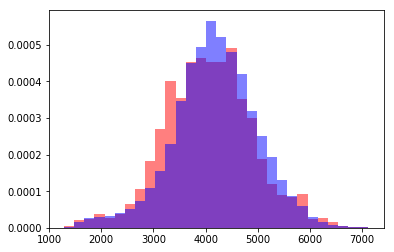

In [20]:
mask = (df1.akpd_score > 0.95) & (df1.hour >= 5) & (df1.hour <= 15)
df2 = df1[mask]

counts, bins, _ = plt.hist(df2.estimated_weight_g, density = True, alpha = 0.5, color = 'red', bins = 30)
plt.hist(pen5.weight * 1000 / 0.84, density = True, alpha = 0.5, color = 'blue', bins = bins)

In [47]:
counts = np.arange(100, 1000, 10)

gt_weight = np.mean(pen5.weight * 1000 / 0.84)

mask = (df1.akpd_score > 0.95) & (df1.hour >= 5) & (df1.hour <= 15)
df2 = df1[mask]

errors = []

for count in counts:
    results = []
    
    for i in np.arange(1000):
        weights = np.mean(np.random.choice(df2.estimated_weight_g, count))

        results.append(np.abs((weights - gt_weight) / gt_weight))

    errors.append(np.mean(results))

Text(0.5, 1.0, 'Vikane Pen 2: Error vs Sample Size')

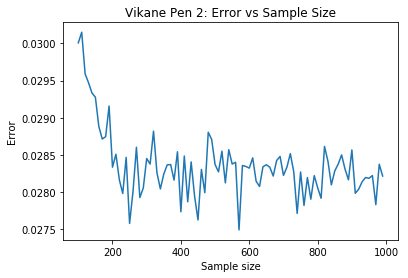

In [49]:
plt.plot(counts, errors)
plt.xlabel('Sample size')
plt.ylabel('Error')
plt.title('Vikane Pen 2: Error vs Sample Size')

In [39]:
counts = np.arange(0.01, 0.99, 0.01)

gt_weight = np.mean(pen5.weight * 1000 / 0.84)

errors = []

for count in counts:
    mask = (df1.akpd_score > count) & (df1.hour >= 5) & (df1.hour <= 15)
    df2 = df1[mask]
    
    weights = np.mean(df2.estimated_weight_g)

    errors.append(np.abs((weights - gt_weight) / gt_weight))

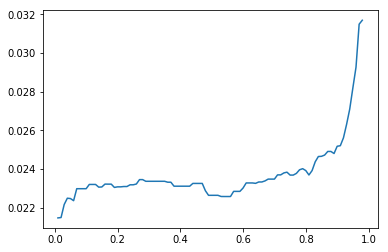

In [40]:
plt.plot(counts, errors)